# Phast - Vessel Leak, Jet Fire and Radiation
In this demo, we're going to model a leak from a vessel and see some discharge results, jet fire flame length results and radiation results.

## Import the required items

In [1]:
import {
  VesselStateCalculation,
  VesselLeakCalculation
} from "./src/calculations/discharge";

import { JetFireCalculation } from "./src/calculations/jetFire";

import { DistancesAndEllipsesToRadiationLevelsCalculation } from "./src/calculations/radiation";

import {
  State,
  Material,
  MaterialComponent,
  Vessel,
  Leak,
  DischargeParameters,
  Weather,
  Substrate,
  FlammableParameters,
  FlammableOutputConfig
} from "./src/entities";

import {
  ResultCode,
  FluidSpec,
  MixtureModelling,
  TimeVaryingOption
} from "./src/enums";

import { setAccessToken } from "./src/utilities";
import { getMaterialByName } from "./src/materials";
import Plotly from "tslab-plotly";
import * as tslab from "tslab";

// Set up access token
const accessToken = process.env.PWS_ACCESS_TOKEN;
if (!accessToken) {
  throw new Error("PWS_ACCESS_TOKEN environment variable is not set.");
}
setAccessToken(accessToken);

## Running discharge calculations

### Define the input data
To run discharge calculations for a leak from a vessel we need, as a minimum, material, pressure, temperature and hole diameter. All units are S.I.

In [2]:
const material = await getMaterialByName("METHANE");
const pressure = 5000000;
const temperature = 293.15;
const holeDiameter = 0.2;

### Calculate the vessel conditions
The discharge calculations needs to know the conditions inside the vessel.

First, define a new State...

In [3]:
const state = new State({
  pressure: pressure,
  temperature: temperature,
  liquidFraction: 0,
  flashFlag: FluidSpec.TP,
  mixtureModelling: MixtureModelling.PC
});

const vesselStateCalculation = new VesselStateCalculation(material, state);

const resultCode = await vesselStateCalculation.run();

if (resultCode === ResultCode.SUCCESS) {
    console.log("Vessel state calculation successful.");
    console.log("The vessel conditions are " + vesselStateCalculation.vesselConditions);
    
    var vesselConditions = vesselStateCalculation.vesselConditions;
} else {
    console.log("Vessel state calculation failed.");
}

Vessel state calculation successful.
The vessel conditions are 1


### Calculate the discharge
Discharge calculations for a leak from a vessel are provided by the VesselLeakCalculation class.

This calculation requires Vessel, Leak and DischargeParameters entities. The properties of these entities can be set when initialising them. Note that the vessel_conditions in the vessel are set to the result from the previous step.

In [4]:
const vessel = new Vessel({
  state: state,
  material: material,
  liquidFillFractionByVolume: 0,
  vesselConditions: vesselStateCalculation.vesselConditions
});

const leak = new Leak({
  holeDiameter: holeDiameter,
  timeVaryingOption: TimeVaryingOption.TIME_VARYING_RATE
});

const dischargeParameters = new DischargeParameters();

const vesselLeakCalculation = new VesselLeakCalculation(
  vessel,
  leak,
  dischargeParameters
);

const resultCode2 = await vesselLeakCalculation.run();

if (resultCode2 === ResultCode.SUCCESS) {
    console.log("Discharge calculations successful.");
} else {
    console.log("Discharge calculations failed.");
}

Discharge calculations successful.


### Plot the discharge results
Get the relevant discharge records and plot mass flow vs time...

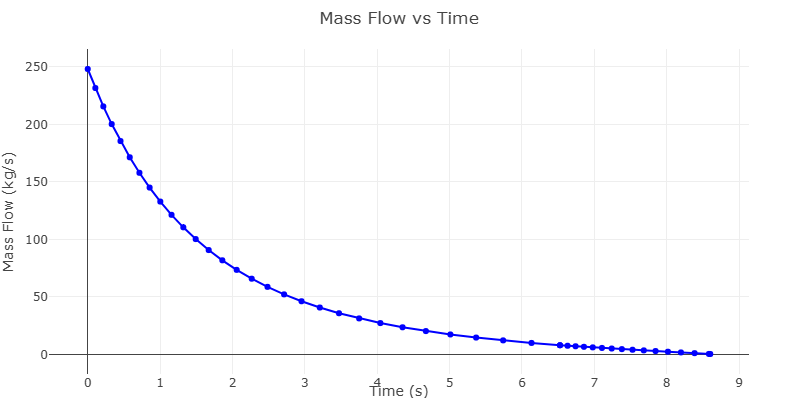

In [5]:
if (vesselLeakCalculation.dischargeRecords) {
    const timeData: number[] = [];
    const massFlowData: number[] = [];
    
    for (const record of vesselLeakCalculation.dischargeRecords) {
        timeData.push(record.time);
        massFlowData.push(record.massFlow);
    }
    
    // Plot mass flow vs time
    Plotly.newPlot(tslab, [{
        type: "scatter",
        mode: "lines+markers",
        x: timeData,
        y: massFlowData,
        marker: {
            color: "blue",
            symbol: "circle"
        },
        line: {
            color: "blue"
        }
    }], {
        title: "Mass Flow vs Time",
        xaxis: { title: "Time (s)" },
        yaxis: { title: "Mass Flow (kg/s)" },
        showlegend: false,
        width: 800,
        height: 400
    });
} else {
    console.log("Discharge calculations failed.");
}

## Running jet fire calculations
A jet fire calculation requires a Material, a Weather, a Substrate, FlammableParameters and some discharge results. In this example, we will use the discharge results from the vesselLeakCalculation. If you have your own discharge results from another method, you can feed those into the jet fire calculation instead.

### Calculate the jet fire
First, define a Weather, Substrate and FlammableParameters...

In [6]:
const weather = new Weather({
  windSpeed: 5
});

const substrate = new Substrate();
const flammableParameters = new FlammableParameters();

const jetFireCalculation = new JetFireCalculation(
  vesselLeakCalculation.exitMaterial!,
  vesselLeakCalculation.dischargeRecords!,
  vesselLeakCalculation.dischargeRecords!.length,
  vesselLeakCalculation.dischargeResult!,
  weather,
  substrate,
  flammableParameters
);

const resultCode3 = await jetFireCalculation.run();

if (resultCode3 === ResultCode.SUCCESS) {
    console.log("Jet fire calculations successful.");
} else {
    console.log("Jet fire calculations failed.");
}

Jet fire calculations successful.


### Review the results
Let's check the calculated flame length and surface emissive power...

In [7]:
if (jetFireCalculation.flameResult) {
    const flameLength = jetFireCalculation.flameResult.flameLength;
    const surfaceEmissivePower = jetFireCalculation.flameResult.surfaceEmissivePower;
    
    console.log(`The flame length is ${flameLength.toFixed(1)} metres`);
    console.log(`The SEP is ${(surfaceEmissivePower / 1000).toFixed(1)} kW/m2`);
}

The flame length is 66.5 metres
The SEP is 294.2 kW/m2


## Running radiation calculations

### Calculate distances and ellipses to radiation levels
Now that we have the jet fire results, we want to determine the thermal radiation results. For this we can use the DistancesAndEllipsesToRadiationLevelsCalculation class and pass the following:

- FlameResult
- list of FlameRecords
- Weather
- FlammableParameters
- list of FlammableOutputConfigs

We already have a Weather and a FlammableParameters from earlier. We just need one or more FlammableOutputConfigs. These FlammableOutputConfigs provide us with the means to specify the results that we are interested in, such as downwind distance to and footprint data for a specified radiation level, transect results or radiation at a particular xyz coordinate. In this example, we want to plot radiation footprint data for three radiation levels: 4, 12.5 and 37.5 kW/m2...

In [8]:
const flammableOutputConfig1 = new FlammableOutputConfig({
    radiationLevel: 4000  // use this for 4 kW/m2
});

const flammableOutputConfig2 = new FlammableOutputConfig({
    radiationLevel: 12500  // use this for 12.5 kW/m2
});

const flammableOutputConfig3 = new FlammableOutputConfig({
    radiationLevel: 37500  // use this for 37.5 kW/m2
});

if (jetFireCalculation.flameResult) {
    console.log("FlameResult:");
    console.log(`Time: ${jetFireCalculation.flameResult.time}`);
    console.log(`Surface Emissive Power: ${jetFireCalculation.flameResult.surfaceEmissivePower}`);
    console.log(`Flame Length: ${jetFireCalculation.flameResult.flameLength}`);
    console.log(`Flame Diameter: ${jetFireCalculation.flameResult.flameDiameter}`);
    console.log(`Fire Type: ${jetFireCalculation.flameResult.fireType}`);
}

FlameResult:
Time: 8.602186000374331
Surface Emissive Power: 294239.5585921572
Flame Length: 66.52212290713686
Flame Diameter: -9.95e+36
Fire Type: 4


In [9]:
const distancesAndEllipsesToRadiationLevelsCalculation = new DistancesAndEllipsesToRadiationLevelsCalculation(
    jetFireCalculation.flameResult!,
    jetFireCalculation.flameRecords!,
    jetFireCalculation.flameRecords!.length,
    weather,
    flammableParameters,
    [flammableOutputConfig1, flammableOutputConfig2, flammableOutputConfig3],
    3
);

const resultCode4 = await distancesAndEllipsesToRadiationLevelsCalculation.run();

if (resultCode4 === ResultCode.SUCCESS) {
    console.log("Radiation calculations successful.");
} else {
    console.log("Radiation calculations failed.");
}

Radiation calculations successful.


### Review the results
The calculation object has a distances property which is a list of downwind distances to the radiation levels in the three flammable output configs.

In [12]:
if (distancesAndEllipsesToRadiationLevelsCalculation.distances) {
    
    // The order of the downwind distances is the same order in which the flammable output configs were specified above
    const distances = distancesAndEllipsesToRadiationLevelsCalculation.distances;
    
    console.log(`The downwind distance to ${flammableOutputConfig1.radiationLevel! / 1000} kW/m2 is ${distances[0].toFixed(1)} metres`);
    console.log(`The downwind distance to ${flammableOutputConfig2.radiationLevel! / 1000} kW/m2 is ${distances[1].toFixed(1)} metres`);
    console.log(`The downwind distance to ${flammableOutputConfig3.radiationLevel! / 1000} kW/m2 is ${distances[2].toFixed(1)} metres`);
}

The downwind distance to 4 kW/m2 is 121.0 metres
The downwind distance to 12.5 kW/m2 is 93.0 metres
The downwind distance to 37.5 kW/m2 is 73.9 metres


### Plot the contour points
Let's now plot an XY footprint of each radiation level.

Since the DistancesAndEllipsesToRadiationLevelsCalculation supports multiple FlammableOutputConfigs, the contour_points are appended together. There are always 50 points per FlammableOutputConfig and the order is always the same order as that in which the FlammableOutputConfigs were passed in.

We can check this as follows to be sure...

In [13]:
 console.log("Number of contour points per config:", distancesAndEllipsesToRadiationLevelsCalculation.nContourPoints);

Number of contour points per config: [ 50, 50, 50 ]


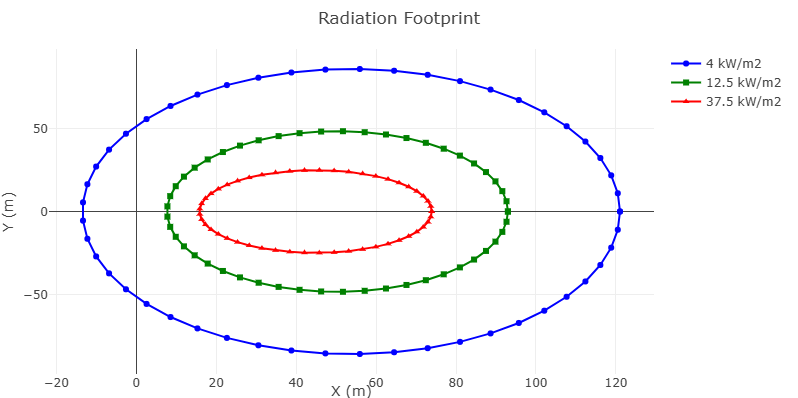

In [14]:
if (distancesAndEllipsesToRadiationLevelsCalculation.nContourPoints) {
    
    // It's worth coding this check into the application in case DNV's APIs were ever modified to give a different number of points per flammable output config
    let startIndex = 0;
    const listOfArrays: Array<{x: number[], y: number[]}> = [];
    
    for (let i = 0; i < distancesAndEllipsesToRadiationLevelsCalculation.flammableOutputConfigs!.length; i++) {
        const numberOfPoints = distancesAndEllipsesToRadiationLevelsCalculation.nContourPoints[i];
        
        const xData: number[] = [];
        const yData: number[] = [];
        
        for (let j = startIndex; j < startIndex + numberOfPoints; j++) {
            const contourPoint = distancesAndEllipsesToRadiationLevelsCalculation.contourPoints![j];
            xData.push(contourPoint.x);
            yData.push(contourPoint.y);
        }
        
        listOfArrays.push({x: xData, y: yData});
        startIndex += numberOfPoints;
    }
    
    // Plot the radiation footprint
    const colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'];
    const markers = ['circle', 'square', 'triangle-up', 'diamond', 'star', 'cross', 'x'];
    const labels = [
        `${flammableOutputConfig1.radiationLevel! / 1000} kW/m2`,
        `${flammableOutputConfig2.radiationLevel! / 1000} kW/m2`,
        `${flammableOutputConfig3.radiationLevel! / 1000} kW/m2`
    ];
    
    const plotData = listOfArrays.map((array, idx) => ({
        type: "scatter" as const,
        mode: "lines+markers" as const,
        x: array.x,
        y: array.y,
        marker: {
            color: colors[idx % colors.length],
            symbol: markers[idx % markers.length]
        },
        line: {
            color: colors[idx % colors.length]
        },
        name: labels[idx % labels.length]
    }));
    
    Plotly.newPlot(tslab, plotData, {
        title: "Radiation Footprint",
        xaxis: { title: "X (m)" },
        yaxis: { title: "Y (m)" },
        showlegend: true,
        width: 800,
        height: 400
    });
}